## DNN

EarlyStopping with Patience

Learning Rate Scheduler

Dropout & BatchNorm Tweaks

Stronger Data Augmentation

Data Normalization Bug Fix

Increased Epochs

Use of torchvision.transforms on PIL Images Efficiently

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cpu
Total: 2501 | Train: 2000 | Val: 250 | Test: 251
Epoch 1/30
Train Loss: 0.6970, Train Acc: 57.45%
Val Loss:   0.6686, Val Acc:   61.60%
############################################################
Epoch 2/30
Train Loss: 0.6502, Train Acc: 62.85%
Val Loss:   0.7015, Val Acc:   62.40%
############################################################
Epoch 3/30
Train Loss: 0.6272, Train Acc: 66.15%
Val Loss:   0.6371, Val Acc:   63.60%
############################################################
Epoch 4/30
Train Loss: 0.6137, Train Acc: 65.25%
Val Loss:   0.5892, Val Acc:   69.20%
############################################################
Epoch 5/30
Train Loss: 0.5809, Train Acc: 68.95%
Val Loss:   0.5668, Val Acc:   68.40%
############################################################
Epoch 6/30
Train Loss: 0.5501, Train Acc: 71.75%
Val Loss:   0.7791, V

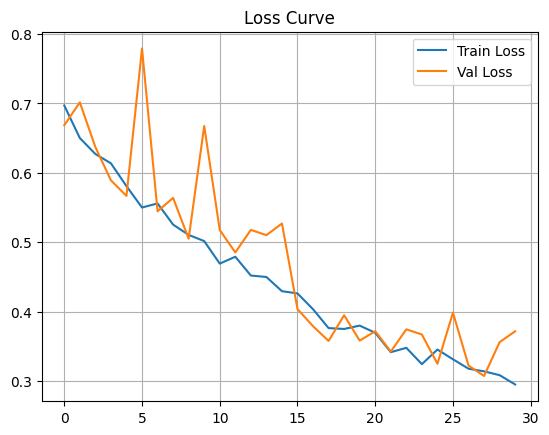

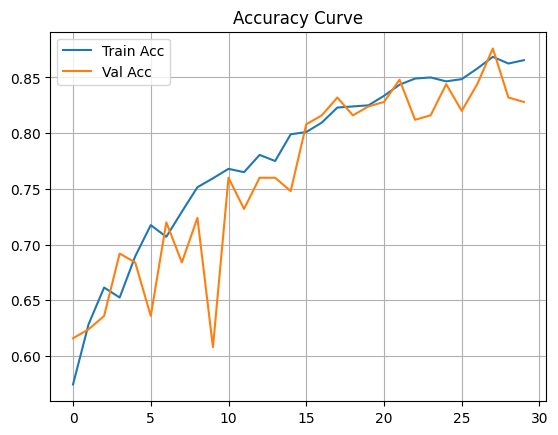

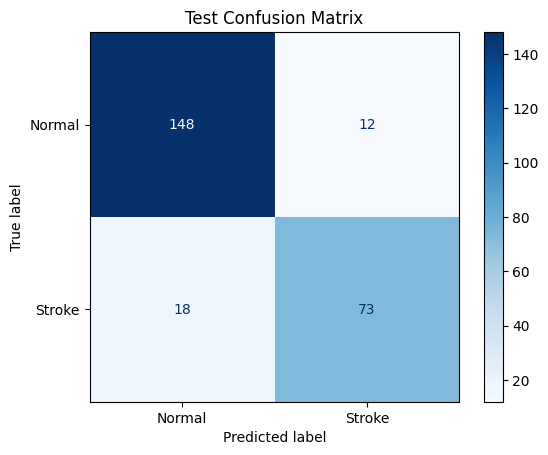

Test Classification Report:
              precision    recall  f1-score   support

      Normal       0.89      0.93      0.91       160
      Stroke       0.86      0.80      0.83        91

    accuracy                           0.88       251
   macro avg       0.88      0.86      0.87       251
weighted avg       0.88      0.88      0.88       251



In [2]:
# STEP 1: SETUP (Same)
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from glob import glob
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# STEP 2: PATHS AND SETTINGS
dataset_path = "/content/drive/MyDrive/Data"
image_size = (224, 224)
num_classes = 2

# STEP 3: LOAD IMAGE PATHS
normal_paths = glob(os.path.join(dataset_path, "Normal", "*.jpg"))
stroke_paths = glob(os.path.join(dataset_path, "Stroke", "*.jpg"))
image_paths = normal_paths + stroke_paths
random.shuffle(image_paths)

# STEP 4: SPLIT DATA
train_ratio = 0.8
train_size = int(train_ratio * len(image_paths))
train_paths = image_paths[:train_size]
test_paths = image_paths[train_size:]
val_paths, test_paths = train_test_split(test_paths, test_size=0.5)

print(f"Total: {len(image_paths)} | Train: {len(train_paths)} | Val: {len(val_paths)} | Test: {len(test_paths)}")

# STEP 5: TRANSFORMS (Improved)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# STEP 6: DATASET CLASS (Same)
class StrokeDataset(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform
        self.label_map = {'Normal': 0, 'Stroke': 1}
        self.labels = [self.label_map[self.get_label(p)] for p in paths]

    def get_label(self, path):
        return os.path.basename(os.path.dirname(path))

    def __getitem__(self, index):
        img = Image.open(self.paths[index]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = self.labels[index]
        return img, label

    def __len__(self):
        return len(self.paths)

# STEP 7: LOADERS (Same)
train_dataset = StrokeDataset(train_paths, transform=train_transform)
val_dataset = StrokeDataset(val_paths, transform=test_transform)
test_dataset = StrokeDataset(test_paths, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# STEP 8: DNN MODEL (Improved)
class DNNModel(nn.Module):
    def __init__(self, num_classes):
        super(DNNModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc_layers = nn.Sequential(
            nn.Linear(224 * 224 * 3, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc_layers(x)
        return x

# STEP 9: INITIALIZE
model = DNNModel(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

# STEP 10: TRAIN FUNCTIONS (Same logic)
def train_epoch():
    model.train()
    running_loss, correct, total = 0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss / len(train_loader), correct / total

def eval_model():
    model.eval()
    running_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(val_loader), correct / total

# STEP 11: TRAIN LOOP WITH EARLY STOPPING & LR Scheduler
n_epochs = 30
best_score = float("inf")
patience = 5
tolerance = 0

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}/{n_epochs}")
    train_loss, train_acc = train_epoch()
    val_loss, val_acc = eval_model()

    scheduler.step(val_loss)

    if val_loss < best_score:
        best_score = val_loss
        torch.save(model.state_dict(), "best_dnn_model.pt")
        tolerance = 0
    else:
        tolerance += 1
        if tolerance >= patience:
            print("Early stopping triggered.")
            break

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2%}")
    print(f"Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.2%}")
    print("#" * 60)

# STEP 12: PLOTS
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss Curve")
plt.legend()
plt.grid()
plt.show()

plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title("Accuracy Curve")
plt.legend()
plt.grid()
plt.show()

# STEP 13: TEST EVALUATION
def get_predictions(loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            _, p = torch.max(outputs, 1)
            preds.extend(p.cpu().numpy())
            labels.extend(lbls.numpy())
    return preds, labels

model.load_state_dict(torch.load("best_dnn_model.pt"))
test_preds, test_labels = get_predictions(test_loader)

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["Normal", "Stroke"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Test Confusion Matrix")
plt.show()

# Classification Report
print("Test Classification Report:")
print(classification_report(test_labels, test_preds, target_names=["Normal", "Stroke"]))
